<a href="https://www.kaggle.com/code/fatimsadixova/house-price-prediction-random-forest-model?scriptVersionId=260532821" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# **A Machine Learning Project: Step-by-Step**

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Upload dataset

In [2]:
train_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')

print(train_df)

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Utilities  ... PoolArea PoolQC  Fe

In [3]:
train = train_df.copy()

# EDA

In [4]:
train.isnull().sum()

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [5]:
train.shape

(1460, 81)

In [6]:
train.describe

<bound method NDFrame.describe of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour 

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# SalePrice Distribution


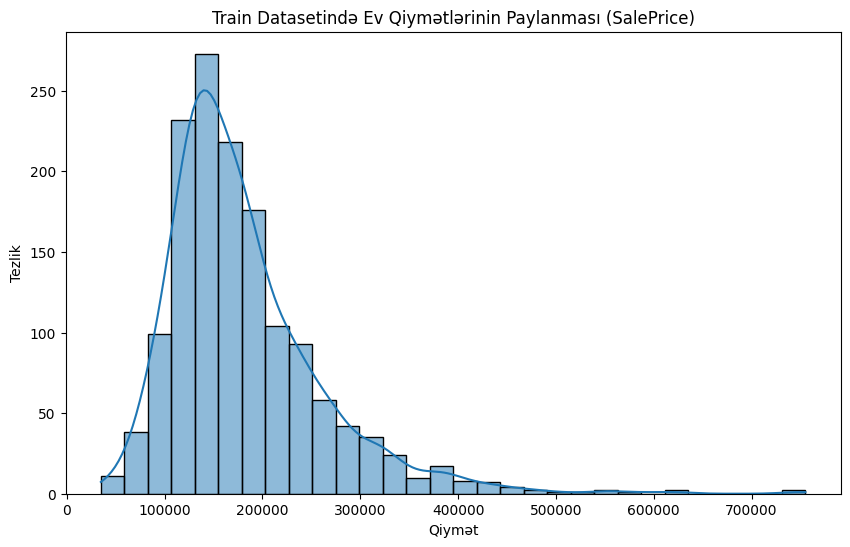

In [8]:
plt.figure(figsize=(10, 6))
sns.histplot(train['SalePrice'], kde=True, bins=30)
plt.title('Train Datasetində Ev Qiymətlərinin Paylanması (SalePrice)')
plt.xlabel('Qiymət')
plt.ylabel('Tezlik')
plt.show()

# Feature Selection

In [9]:
# X və y hissələrini ayırırıq
# X: bütün xüsusiyyətlər, yəni SalePrice və Id xaricindəki bütün sütunlar
X = train.drop(['Id', 'SalePrice'], axis=1)

# y: hədəf dəyişəni SalePrice
# Modelin daha yaxşı öyrənməsi üçün loqarifmik çevirmə tətbiq edirik
y = np.log1p(train['SalePrice'])

In [10]:
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

X shape: (1460, 79)
y shape: (1460,)


In [11]:
# Sayısal və kategorik xüsusiyyətləri ayırmaq
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

# **Pipeline & Model Building**

We build Pipeline to automate the machine learning process. A pipeline is a chain that connects several steps in sequence.

Why do we use Pipeline?

Automation: Automates all pre-processing steps (filling in blanks, converting data).

Consistency: It applies all the transformations we do on the training data to the test data as well.

Preventing Data Leakage: This is the most important reason. Pipeline applies the statistics it learns from the training data (such as the median or the most frequent value) to the test data. This prevents the model from "seeing" any information from the test data.

In [12]:
# Pipeline içində boş dəyərləri doldurmaq
numerical_transformer = SimpleImputer(strategy='median')
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Ön-işləmə üçün ColumnTransformer hazırlayırıq
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Ön-işləmə və modeli birləşdirən əsas pipeline-ı qururuq
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=1000, random_state=42, n_jobs=-1))
])

print("Ön-işləmə və model pipeline-ı uğurla quruldu.")

Ön-işləmə və model pipeline-ı uğurla quruldu.


# **Evaluating the Model (Cross-Validation)**

We need to evaluate our model to see how good it is. For this we use Cross-Validation.

How does it work?

We divide the data into 5 parts.

Each time we use 4 parts for training and one part for testing.

This allows us to test how our model performs on different data.

Why do we do this?

This helps us get a reliable idea of ​​the true performance of the model and protects us from misleading results.

In [13]:
# K-Fold Cross-Validation tətbiq etmək
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)

# RMSE nəticələrini saxlamaq üçün boş bir siyahı
rmse_scores = []

print("Cross-Validation prosesi başlayır...")
for fold, (train_index, val_index) in enumerate(kf.split(X, y)):
    X_train, X_val = X.iloc[train_index], X.iloc[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    # Modeli təlim etmək (imputation və encoding artıq pipeline içindədir)
    model_pipeline.fit(X_train, y_train)

    # Validation hissəsi üzərində proqnozlar etmək
    y_pred = model_pipeline.predict(X_val)

    # Bu fold üçün RMSE-ni hesablamaq
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    rmse_scores.append(rmse)

    print(f"Fold {fold+1} üçün RMSE: {rmse:.4f}")

# Bütün foldların ortalama RMSE-sini hesablamaq
mean_rmse = np.mean(rmse_scores)
std_rmse = np.std(rmse_scores)

print("\n------------------------------")
print(f"Bütün foldlar üçün Ortalama RMSE: {mean_rmse:.4f}")
print(f"RMSE dəyərlərinin Standart Kənarlaşması: {std_rmse:.4f}")
print("------------------------------")

Cross-Validation prosesi başlayır...
Fold 1 üçün RMSE: 0.1465
Fold 2 üçün RMSE: 0.1273
Fold 3 üçün RMSE: 0.1773
Fold 4 üçün RMSE: 0.1491
Fold 5 üçün RMSE: 0.1234

------------------------------
Bütün foldlar üçün Ortalama RMSE: 0.1447
RMSE dəyərlərinin Standart Kənarlaşması: 0.0192
------------------------------


# **Building the Final Model and Making Predictions**

With Cross-Validation, we made sure that our model works well.

Now we train our final model on all train data and make predictions on test.csv to get the best result.

### **What is the final model?**

This is the most powerful version we will use to make predictions on test.csv.

We train it on all the training data so that it gets the most knowledge possible.

Building the Final Model and Making Predictions
With Cross-Validation, we made sure that our model works well. Now we train our final model on all train data and make predictions on test.csv to get the best result.

### **What is the final model?**

This is the most powerful version we will use to make predictions on test.csv.

We train it on all the training data so that it gets the most knowledge possible.

In [14]:
# Final modeli bütün verilər üzərində təlim edirik.
print("Final model bütün dataset üzərində təlim edilir...")
model_pipeline.fit(X, y)
print("Təlim tamamlandı.")

Final model bütün dataset üzərində təlim edilir...
Təlim tamamlandı.


In [15]:
# test.csv faylını yükləyirik
test_df = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

# 'Id' sütununu gələcək üçün saxlayıriq
test_ids = test_df['Id']
X_kaggle_test = test_df.drop('Id', axis=1)

# `train.csv` üzərində etdiyin Feature engineering addımlarını
# `test.csv` üzərində tətbiq edirik
X_kaggle_test['TotalSF'] = X_kaggle_test['TotalBsmtSF'] + X_kaggle_test['1stFlrSF'] + X_kaggle_test['2ndFlrSF']
X_kaggle_test['YearsSinceBuilt'] = X_kaggle_test['YrSold'] - X_kaggle_test['YearBuilt']
X_kaggle_test['YearsSinceRemodel'] = X_kaggle_test['YrSold'] - X_kaggle_test['YearRemodAdd']

print("\nKaggle test dataseti hazırlandı.")



Kaggle test dataseti hazırlandı.


In [16]:
# Hazırlanmış test dataseti üzərində proqnozlar əldə edin.
# Pipeline bütün təmizləmə addımlarını avtomatik yerinə yetirir.
final_predictions = model_pipeline.predict(X_kaggle_test)

# Proqnozları loqarifmik çevirmədən geri qaytarın.
final_predictions = np.expm1(final_predictions)


In [17]:
# Nəticəni submission.csv faylına yazın.
submission_df = pd.DataFrame({'Id': test_ids, 'SalePrice': final_predictions})
submission_df.to_csv('submission.csv', index=False)


In [18]:
print("\nFinal Yükləmə Faylı (ilk 5 sətir):")
print(submission_df.head())


Final Yükləmə Faylı (ilk 5 sətir):
     Id      SalePrice
0  1461  126174.945729
1  1462  152263.889958
2  1463  179945.008688
3  1464  180848.995644
4  1465  196427.581809


In [19]:
submission_df

,Id,SalePrice
0,1461,126174.945729
1,1462,152263.889958
2,1463,179945.008688
3,1464,180848.995644
4,1465,196427.581809
...,...,...
1454,2915,83880.198924
1455,2916,85001.266252
1456,2917,151854.265735
1457,2918,115603.462874
